# EU Emissions Per Capita

In [ ]:
# install all required packages
!pip install -r ../requirements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file_defaults()
import eurostat

## Prepare the dataset

In [2]:
# country codes for EU28 based on ISO 3166 alpha-2
eu28 = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI', 'FR', 'HR', 'HU',
        'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'UK']

In [3]:
geo_dic = eurostat.get_dic('geo')

In [4]:
# create a dataframe with all EU countries and with a sane name for Germany
df = pd.DataFrame({'code': eu28, 'country': [geo_dic[c] if c != 'DE' else 'Germany' for c in eu28]})

In [5]:
# load population data
# - subset the table only on totals over age and sex
pop_raw = eurostat.get_data_df('demo_pjan', flags=False).query('age == "TOTAL" and sex == "T"')

In [6]:
pop = pop_raw[[r'geo\time', 2018]].rename(columns={r'geo\time': 'code', 2018: 'pop'})
pop['pop'] = np.int_(pop['pop'])

In [7]:
# load greenhouse gases table and filter on:
# - airpol == GHG means all greenhouse gases, expressed as CO2 equivalent
# - src_crf == TOTX4_MEMONIA means total emissions, excluding LULUCF and memo items, including international aviation
# - unit == MIO_T means the values are expressed in million tonnes
ghg_raw = eurostat.get_data_df('env_air_gge', flags=False) \
    .query('airpol == "GHG" and src_crf == "TOTX4_MEMONIA" and unit == "MIO_T"')

In [8]:
ghg = ghg_raw[[r'geo\time', 2018]].rename(columns={r'geo\time': 'code', 2018: 'ghg'})

In [9]:
# merge all datasets together on country codes
df = pd.merge(pd.merge(df, pop), ghg)

In [10]:
# emissions per capita, in tonnes per capita per year
df['ghg_per_capita'] = 1e6 * df['ghg'] / df['pop']

In [11]:
# this is the dataset stored under data/eu-emissions-2018.csv
# df.to_csv('../data/eu-emissions-2018.csv', index=False)
df

,code,country,pop,ghg,ghg_per_capita
0,AT,Austria,8822267,81.50147,9.238155
1,BE,Belgium,11398589,123.64290,10.847211
2,BG,Bulgaria,7050034,58.59507,8.311317
3,CY,Cyprus,864236,9.85631,11.404651
4,CZ,Czechia,10610055,129.38768,12.194817
5,DE,Germany,82792351,888.71856,10.734308
6,DK,Denmark,5781190,51.29975,8.873562
7,EE,Estonia,1319133,20.18452,15.301353
8,EL,Greece,10741165,96.11319,8.948116
9,ES,Spain,46658447,352.20855,7.548656


## Plot the results

In [ ]:
# if you want to avoid creating the dataset, just load it from the file
df = pd.read_csv('../data/eu-emissions-2018.csv')

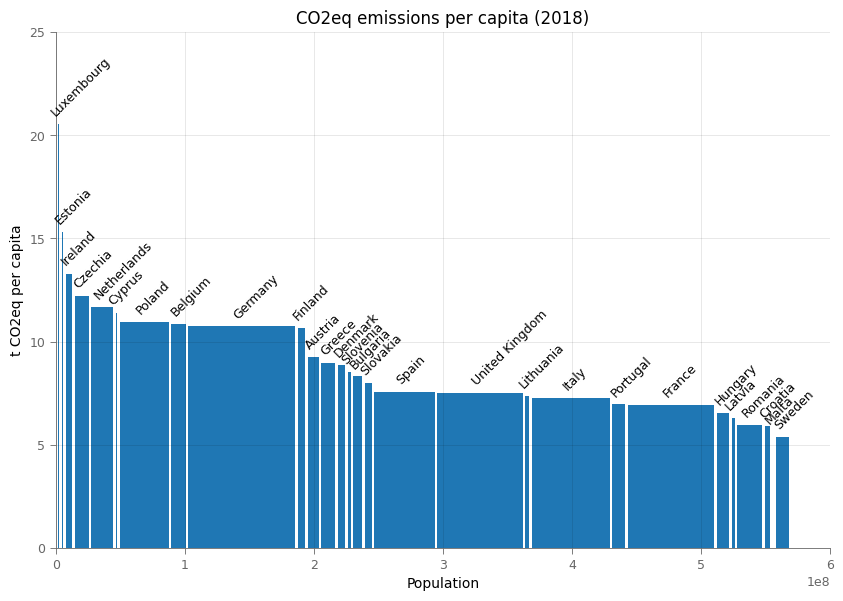

In [12]:
fig, ax = plt.subplots()

x = 0
xgap = 2e6
ygap = 0.4

for i, row in df.sort_values('ghg_per_capita', ascending=False).iterrows():
    x = x + xgap
    plt.text(x + 0.5 * row['pop'] - 4 * xgap, row['ghg_per_capita'] + ygap, row['country'], rotation=45, fontsize=9)
    rec = mpl.patches.Rectangle((x, 0), row['pop'], row['ghg_per_capita'])  #, ec=None, fc=cs[i % 2])
    ax.add_patch(rec)
    x = x + row['pop']

ax.set(xlim=(0, 6e8), ylim=(0, 25))
ax.set(xlabel='Population', ylabel='t CO2eq per capita', title='CO2eq emissions per capita (2018)')

plt.show()